## Import & Process Image

In [62]:
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications.vgg16 import VGG16

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import glob

# from src.functions import preprocess_image, load_and_preprocess_image

AUTOTUNE = tf.data.experimental.AUTOTUNE ## tf.data transformation parameters

pd.options.display.max_columns = 100

## Data Cleaning

In [18]:
## This code will only work if you have all the images already downloaded on your EC2
img_url = sorted(glob.glob('data/ISIC-images'+"/*.jpg"))
csv_names = [i for i in glob.glob('data'+'/*.csv')]
df = pd.read_csv('data/metadata.csv')

short=[]
for i in img_url:
    short.append(i[17:-4])
img_name = pd.Series(short,name='name')

df = pd.merge(df, img_name, on='name', how='inner')
df['image'] = img_url

df = df[['meta.clinical.diagnosis', 'image']]
df_na = df.copy()
df = df[df['meta.clinical.diagnosis'].notna()].reset_index(drop=True)
df.columns = ['diagnosis', 'image']
df['diagnosis'] = (df['diagnosis'] == 'melanoma').astype(int)

#### Deleted null values from dataset

In [3]:
df_na[df_na['meta.clinical.diagnosis'].isna()]

,meta.clinical.diagnosis,image
257,NaN,data/ISIC-images/ISIC_0000257.jpg
454,NaN,data/ISIC-images/ISIC_0000454.jpg
9892,NaN,data/ISIC-images/ISIC_0009892.jpg
9893,NaN,data/ISIC-images/ISIC_0009893.jpg
9924,NaN,data/ISIC-images/ISIC_0009924.jpg
...,...,...
13786,NaN,data/ISIC-images/ISIC_0024202.jpg
13787,NaN,data/ISIC-images/ISIC_0024203.jpg
13788,NaN,data/ISIC-images/ISIC_0024204.jpg
13789,NaN,data/ISIC-images/ISIC_0024205.jpg


##### df = All dataset

## EDA

In [4]:
diagnosis = df['diagnosis']

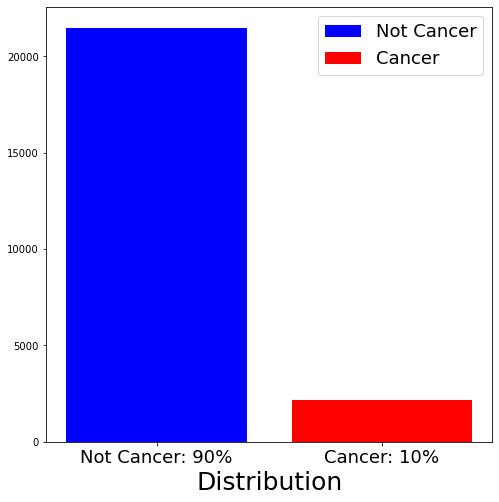

In [9]:
fig, ax = plt.subplots(figsize=(8,8))
xlabel = 25
xtick = 18
x0 = (diagnosis==0).sum()
x1 = (diagnosis==1).sum()

ax.set_xlabel('Distribution', size=xlabel)

ax.bar(0, x0, color = 'b', label='Not Cancer')
ax.bar(1, x1, color = 'r', label='Cancer')
ax.set_xticks([0,1])
ax.set_xticklabels(['Not Cancer: 90%', 'Cancer: 10%'], size=xtick)
plt.legend(prop={'size': 18})
plt.show()

## Pipeline

In [6]:
def preprocess_image(image, imgage_shape=[100,100]):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, imgage_shape)
    image /= 255.0  # normalize to [0,1] range
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def create_X_y(df):
    y = df['diagnosis']
    X = []
    for i in df['image']:
        image = load_and_preprocess_image(i)
        X.append(np.asarray(image))
    return np.asarray(X), np.asarray(y)

#### Creating Test Set and Save processed image set

In [27]:
# Code to create X and y.
# X, y = create_X_y(df)

In [22]:
# Save to instance
# np.save('data/100x100.npy', X)
# np.save('data/diagnosis.npy', y)

In [23]:
import boto3
s3 = boto3.client('s3')

In [7]:
# Uploading 'X' to AWS S3 from original AWS instance
s3.upload_file(Filename='data/100x100.npy',
              Bucket='cancer-images-project',
              Key='100x100.npy')

In [21]:
# Downloading 'X' from AWS S3 to new AWS instance
s3.download_file(Bucket='cancer-images-project',
                 Key='100x100.npy',
                 Filename='data/100x100.npy')

In [24]:
# Uploading 'y' to AWS S3 from original AWS instance
s3.upload_file(Filename='data/diagnosis.npy',
              Bucket='cancer-images-project',
              Key='diagnosis.npy')

In [24]:
# Downloading 'y' from AWS S3 to new AWS instance
s3.download_file(Bucket='cancer-images-project',
                 Key='diagnosis.npy',
                 Filename='data/diagnosis.npy')

#### Train Test Split for Train, validation, test set

In [128]:
X = np.load('data/100x100.npy')
y = np.load('data/diagnosis.npy')

In [129]:
# Train/test split for Train Set
XX_train, X_test, yy_train, y_test = train_test_split(np.asarray(X), np.asarray(y), test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(XX_train, yy_train, test_size=0.2, random_state=42, stratify=yy_train)

#### Train Model

In [110]:
# First VGG Model
## Import Model
model = VGG16(include_top=False, input_shape=(100, 100, 3))

## Transfer Learning
new_model = Sequential()
for layer in model.layers: # just exclude the last two FC layers
    layer.trainable = False
    new_model.add(layer)
new_model.add(Flatten())
new_model.add(Dense(128, activation='relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(1, activation ='sigmoid'))

In [111]:
opt = keras.optimizers.SGD(learning_rate=0.01)
new_model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.Recall()])

In [112]:
history = new_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
117/474 [======>.......................] - ETA: 2:41 - loss: 0.2831 - accuracy: 0.9057 - recall_9: 0.0281

KeyboardInterrupt: 

In [98]:
## Runing now

In [113]:
## Import Model
model = VGG16(include_top=False, input_shape=(100, 100, 3))

## Transfer Learning
new_model = Sequential()
for layer in model.layers[:-2]: # just exclude the last two FC layers
    layer.trainable = False
    new_model.add(layer)
new_model.add(Conv2D(512, (5, 5), activation = 'relu', padding = 'same'))
new_model.add(MaxPooling2D(2,2))
new_model.add(Flatten())
new_model.add(Dense(128, activation='relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(1, activation ='sigmoid'))

In [114]:
opt = keras.optimizers.SGD(learning_rate=0.01)
new_model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.Recall()])

In [115]:
history = new_model.fit(X_train, y_train, epochs=20, batch_size=32, class_weight=class_weight, validation_data=(X_test, y_test))

Epoch 1/20
474/474 [==============================] - 338s 714ms/step - loss: 0.0760 - accuracy: 0.7443 - recall_10: 0.8248 - val_loss: 0.9843 - val_accuracy: 0.5295 - val_recall_10: 0.9954
Epoch 2/20
474/474 [==============================] - 338s 712ms/step - loss: 0.0682 - accuracy: 0.7556 - recall_10: 0.8645 - val_loss: 0.4437 - val_accuracy: 0.7489 - val_recall_10: 0.8502
Epoch 3/20
474/474 [==============================] - 340s 718ms/step - loss: 0.0648 - accuracy: 0.7644 - recall_10: 0.8782 - val_loss: 0.4535 - val_accuracy: 0.7461 - val_recall_10: 0.8594
Epoch 4/20
474/474 [==============================] - 337s 711ms/step - loss: 0.0626 - accuracy: 0.7689 - recall_10: 0.8955 - val_loss: 0.2542 - val_accuracy: 0.8791 - val_recall_10: 0.5000
Epoch 5/20
474/474 [==============================] - 341s 719ms/step - loss: 0.0607 - accuracy: 0.7777 - recall_10: 0.8947 - val_loss: 0.4247 - val_accuracy: 0.7457 - val_recall_10: 0.8733
Epoch 6/20
474/474 [==============================

In [79]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='SAME', input_shape=(100,100,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='SAME'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='SAME'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [80]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
activation_35 (Activation)   (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 50, 50, 32)        9248      
_________________________________________________________________
activation_36 (Activation)   (None, 50, 50, 32)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 25, 25, 64)       

In [81]:
opt = keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.Recall()])

In [83]:
# Calculate imbalance data
ones = (y_train==1).sum()
zeros = (y_train==0).sum()
adj_ones = zeros/(ones+zeros)
adj_zero = ones/(ones+zeros)

print('Adjusted Zeros Ratio: {}'.format(adj_ones))
print('Adjusted Ones  Ratio: {}'.format(adj_zero))

Adjusted Zeros Ratio: 0.9083702186694854
Adjusted Ones  Ratio: 0.09162978133051464


In [84]:
class_weight = {1:adj_ones,
                0:adj_zero}

In [85]:
class_weight

{1: 0.9083702186694854, 0: 0.09162978133051464}

In [86]:
history = model.fit(X_train, y_train, epochs=10, class_weight=class_weight, validation_data=(X_test, y_test))

Epoch 1/10
474/474 [==============================] - 67s 141ms/step - loss: 0.1149 - accuracy: 0.5795 - recall_6: 0.4795 - val_loss: 0.6717 - val_accuracy: 0.8252 - val_recall_6: 0.3571
Epoch 2/10
474/474 [==============================] - 65s 138ms/step - loss: 0.1133 - accuracy: 0.5859 - recall_6: 0.5840 - val_loss: 0.6011 - val_accuracy: 0.8804 - val_recall_6: 0.1244
Epoch 3/10
474/474 [==============================] - 65s 137ms/step - loss: 0.1112 - accuracy: 0.6582 - recall_6: 0.5516 - val_loss: 1.1883 - val_accuracy: 0.0919 - val_recall_6: 1.0000
Epoch 4/10
474/474 [==============================] - 65s 137ms/step - loss: 0.1091 - accuracy: 0.6557 - recall_6: 0.5977 - val_loss: 0.5189 - val_accuracy: 0.8400 - val_recall_6: 0.2834
Epoch 5/10
474/474 [==============================] - 64s 135ms/step - loss: 0.1072 - accuracy: 0.6900 - recall_6: 0.5919 - val_loss: 0.6835 - val_accuracy: 0.6481 - val_recall_6: 0.6774
Epoch 6/10
474/474 [==============================] - 64s 135ms/s

In [116]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def plot_recall(history, recall):
    plt.plot(history.history[recall])
    plt.plot(history.history['val_'+recall])
    plt.title('model recall')
    plt.ylabel('recall')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

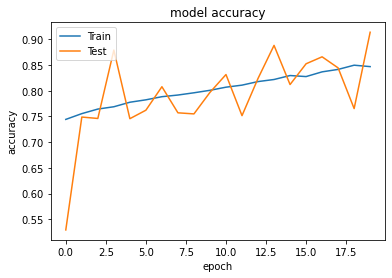

In [117]:
plot_accuracy(history)

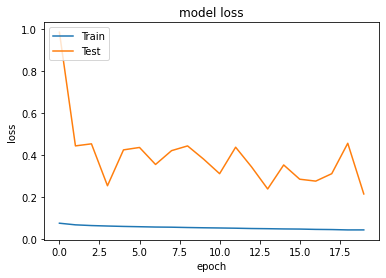

In [118]:
plot_loss(history)

In [119]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'recall_10', 'val_loss', 'val_accuracy', 'val_recall_10'])

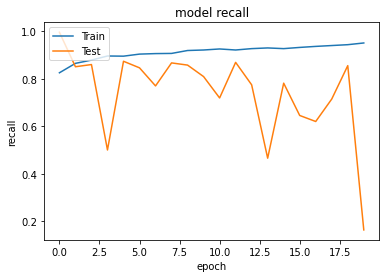

In [120]:
plot_recall(history, 'recall_10')

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
activation_10 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_11 (Activation)   (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 21, 64)       

## Evalaution

In [133]:
# Validation Set
val_loss, val_acc, val_recall = new_model.evaluate(X_val, y_val, verbose=0)
print('Val  set accuracy {:5.2f}%'.format(100*val_acc))
print('Val  set recall   {:5.2f}%'.format(100*val_recall))

# Test Set
test_loss, test_acc, test_recall = new_model.evaluate(X_test, y_test, verbose=0)
print('Test set accuracy {:5.2f}%'.format(100*test_acc))
print('Test set recall   {:5.2f}%'.format(100*test_recall))


Val  set accuracy 91.55%
Val  set recall   16.14%
Test set accuracy 91.38%
Test set recall   16.36%


In [125]:
def matrix_score(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(np.array([[tp, fn],[fp, tn]]))
    print('Recall:    {:.3f}'.format(tp/(tp+fn)))
    print('Precision: {:.3f}'.format(tp/(tp+fp)))
    print('Accuracy:  {:.3f}'.format((tp+tn)/(tp+tn+fp+fn)))
    print('ROC AUC:   {:.3f}'.format(roc_auc_score(y_test, y_pred)))

In [126]:
threshold = 0.105

In [130]:
# Validation Set
result = (new_model.predict(X_val) > threshold).astype(int)
result =[i[0] for i in result]
y_val_pred = np.asarray(result)

matrix_score(y_val, y_val_pred)

[[ 282   65]
 [ 654 2784]]
Recall:    0.813
Precision: 0.301
Accuracy:  0.810
ROC AUC:   0.811


In [131]:
# Test Set
result = (new_model.predict(X_test) > threshold).astype(int)
result =[i[0] for i in result]
y_test_pred = np.asarray(result)

matrix_score(y_test, y_test_pred)

[[ 344   90]
 [ 887 3410]]
Recall:    0.793
Precision: 0.279
Accuracy:  0.793
ROC AUC:   0.793


## ROC AUC

In [135]:
new_model.save('models/vgg_transfer_1.h5')
new_model = load_model('models/vgg_transfer_1.h5')

In [121]:
y_pred_keras = new_model.predict(X_test).ravel()

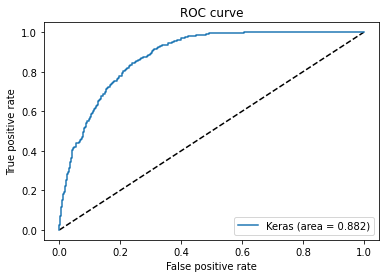

In [122]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [123]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [124]:
Find_Optimal_Cutoff(y_test, y_pred_keras)

[0.10503160953521729]

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_keras)
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

In [56]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_test_pred)
auc_keras = auc(fpr_keras, tpr_keras)

In [96]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_test_pred)
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

ValueError: multilabel-indicator format is not supported

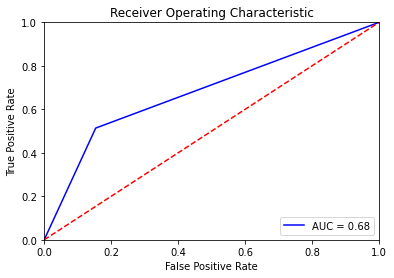

In [31]:
fpr, tpr, threshold = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

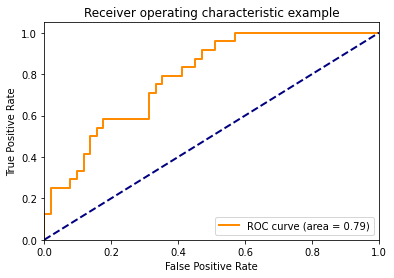

In [94]:
y_score.ravel()

array([-0.76301132, -0.36482547,  0.12386354, -0.20224493, -0.63144366,
       -0.16612302,  0.11801481, -0.80263073, -0.32055874, -0.90780855,
       -0.12395478,  0.02199789, -0.01116192, -0.27913475, -0.71889214,
       -0.6048727 , -0.34730509, -0.05859016,  0.02283491, -0.24506467,
       -0.79111998, -0.61076876,  0.18264917, -0.57199363, -0.37572754,
       -0.24059516, -0.38933694, -0.47017411, -0.25745136, -0.27510839,
       -0.42224234, -0.30270719, -0.27995197, -0.3355867 , -0.7030665 ,
        0.02530178, -0.22723929, -0.64062258, -0.13456902, -0.07856729,
       -0.46354017, -0.45918364, -0.53383361, -0.2653183 , -0.20023832,
        0.12163662, -0.56706353, -0.56980985, -0.71356947, -0.04226738,
       -0.24297128, -0.55111511, -0.13784913, -0.31370595,  0.37991331,
       -0.99673302, -0.39090964, -0.11107635, -0.91349462,  0.03129167,
       -0.70713712, -0.06436533, -0.21423788, -0.02392675, -0.45906496,
       -0.51922684, -0.25045747, -0.80086123,  0.04121338,  0.12